### 4. Implementar *momentum* como variante

En esta sección se implementa momentum como variante. Dado por la fórmula planteada en el notebook:

$$ v^{(t+1)} \leftarrow \mu v^{(t)} - \eta \nabla_{w^{(t)}} Loss \\
w^{(t+1)} \leftarrow w^{(t)} + v^{(t+1)}
$$

Usando como referencia el código del punto 1, la incorporación del momentum modifica 2 funciones

```python

    def __init__(self, nro_entradas, k, loss="mse", activacion=[sigmoid, sigmoid_derivada], momentum=False):
        self.nro_entradas = nro_entradas
        self.k = k
        self.loss = loss
        self.momentum = momentum
        self.entrada = Capa(a=np.ones((1, nro_entradas)))
        self.capa1 = Capa(w=np.random.rand(nro_entradas, 32),
                          v=np.zeros((nro_entradas, 32)),
                          funcion_activacion=activacion[0],
                          der_func_activacion=activacion[1])
        self.capa2 = Capa(w=np.random.rand(32, 16),
                          v=np.zeros((32, 16)),
                          funcion_activacion=activacion[0],
                          der_func_activacion=activacion[1])
        self.salida = Capa(w=np.random.rand(16, k),
                           v=np.zeros((16, k)),
                           funcion_activacion=softmax,
                           der_func_activacion=softmax_derivada)


```

```python
    def stochastic_gradient_descent(self, ejemplos, epochs, tasa_aprendizaje, graficar=False):
        costes = list()
        for e in range(epochs):
            coste = 0
            np.random.shuffle(ejemplos)
            for v in ejemplos:
                self.forward_pass(v[0:self.nro_entradas][np.newaxis])
                self.backward_pass(v[self.nro_entradas:][np.newaxis])
                capas = [self.entrada, self.capa1, self.capa2, self.salida]
                for c in range(len(capas)-1, 0, -1):
                    if not self.momentum:
                        capas[c].w -= tasa_aprendizaje*capas[c].dw
                    else:
                        capas[c].v = 0.5*capas[c].v - tasa_aprendizaje*capas[c].dw
                        capas[c].w += capas[c].v
                perdida = 0
                if self.loss == "mse":
                    perdida = mse(self.salida.a, v[self.nro_entradas:][np.newaxis])
                elif self.loss == "categorical_crossentropy":
                    perdida = cross_entropy(self.salida.a, v[self.nro_entradas:][np.newaxis])
                coste += perdida

            costes.append(coste/ejemplos.shape[0])
```


A continuación, se ejecutará el codigo el codigo completo, utilizando momentum




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris


def cross_entropy(empirico, teorico):
    emp_acotado = np.clip(empirico, 1e-12, 1.0-1e-12)
    return -(teorico*np.log(emp_acotado)).sum()


def mse(empirico, teorico):
    return (1 / 2) * np.sum(np.square(np.subtract(empirico, teorico)))


def relu(matriz):
    return matriz * (matriz > 0)


def relu_derivada(matriz):
    return 1.0 * (matriz > 0)


def sigmoid(matriz):
    return 1.0 / (1.0 + np.exp(-matriz))


def sigmoid_derivada(matriz):
    return sigmoid(matriz) * (1.0 - sigmoid(matriz))


def softmax(matriz):
    a = np.max(matriz)
    m = np.subtract(matriz, a)
    e_x = np.exp(m)
    return e_x / e_x.sum()


def softmax_derivada(matriz):
    return softmax(matriz) * (1 - softmax(matriz))


class Capa(object):
    def __init__(self, z=None, a=None, w=None, v=None, funcion_activacion=None, der_func_activacion=None):
        self.z = z
        self.a = a
        self.w = w
        self.v = v
        self.dw = None
        self.g_prima = None
        self.d = None
        self.funcion_delta = funcion_activacion
        self.funcion_delta_prima = der_func_activacion


class RedNeuronal(object):
    def __init__(self, nro_entradas, k, loss="mse", activacion=[sigmoid, sigmoid_derivada], momentum=False):
        self.nro_entradas = nro_entradas
        self.k = k
        self.loss = loss
        self.momentum = momentum
        self.entrada = Capa(a=np.ones((1, nro_entradas)))
        self.capa1 = Capa(w=np.random.rand(nro_entradas, 32),
                          v=np.zeros((nro_entradas, 32)),
                          funcion_activacion=activacion[0],
                          der_func_activacion=activacion[1])
        self.capa2 = Capa(w=np.random.rand(32, 16),
                          v=np.zeros((32, 16)),
                          funcion_activacion=activacion[0],
                          der_func_activacion=activacion[1])
        self.salida = Capa(w=np.random.rand(16, k),
                           v=np.zeros((16, k)),
                           funcion_activacion=softmax,
                           der_func_activacion=softmax_derivada)

    def forward_pass(self, vector_entrada):
        self.entrada.a = vector_entrada
        capas = [self.entrada, self.capa1, self.capa2, self.salida]
        for i1 in range(len(capas)-1):
            capas[i1 + 1].z = np.dot(capas[i1].a, capas[i1+1].w)
            capas[i1 + 1].a = capas[i1+1].funcion_delta(capas[i1 + 1].z)
            capas[i1 + 1].g_prima = capas[i1+1].funcion_delta_prima(capas[i1 + 1].z)

    def backward_pass(self, ys_teoricas):
        capas = [self.entrada, self.capa1, self.capa2, self.salida]
        if self.loss == "mse":
            capas[-1].d = np.multiply(np.subtract(capas[-1].a, ys_teoricas), capas[-1].g_prima)
        elif self.loss == "categorical_crossentropy":
            capas[-1].d = capas[-1].a - ys_teoricas
        for i1 in range(len(capas) - 2, 0, -1):
            capas[i1].d = np.multiply(capas[i1].g_prima, np.dot(capas[i1 + 1].d, capas[i1 + 1].w.T))
        for i2 in range(len(capas) - 1):
            capas[i2 + 1].dw = np.dot(capas[i2].a.T, capas[i2 + 1].d)

    def f(self, entrada):
        self.forward_pass(entrada)
        return self.salida.a

    def stochastic_gradient_descent(self, ejemplos, epochs, tasa_aprendizaje, graficar=False):
        costes = list()
        for e in range(epochs):
            coste = 0
            np.random.shuffle(ejemplos)
            for v in ejemplos:
                self.forward_pass(v[0:self.nro_entradas][np.newaxis])
                self.backward_pass(v[self.nro_entradas:][np.newaxis])
                capas = [self.entrada, self.capa1, self.capa2, self.salida]
                for c in range(len(capas)-1, 0, -1):
                    if not self.momentum:
                        capas[c].w -= tasa_aprendizaje*capas[c].dw
                    else:
                        capas[c].v = 0.5*capas[c].v - tasa_aprendizaje*capas[c].dw
                        capas[c].w += capas[c].v
                perdida = 0
                if self.loss == "mse":
                    perdida = mse(self.salida.a, v[self.nro_entradas:][np.newaxis])
                elif self.loss == "categorical_crossentropy":
                    perdida = cross_entropy(self.salida.a, v[self.nro_entradas:][np.newaxis])
                coste += perdida

            costes.append(coste/ejemplos.shape[0])

        if graficar:
            plt.plot(np.arange(epochs), costes)
            # plt.ylim(0, 1)
            plt.xlabel('Epochs')
            plt.ylabel('Perdida')
            plt.title(str('Epochs: ' + str(epochs) + ', Tasa: ' + str(tasa_aprendizaje)))
            plt.show()


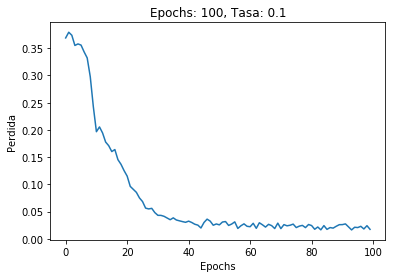

In [4]:
NRO_ENTRADAS=4
K=3
x_train, y_train = load_iris(return_X_y=True)
binarize = np.zeros((y_train.size, 3))
binarize[np.arange(y_train.size), y_train] = 1
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
dataset = np.concatenate((x_train, binarize), axis=1)
np.random.shuffle(dataset)
rn = RedNeuronal(NRO_ENTRADAS, K, "mse", [sigmoid, sigmoid_derivada], True)
rn.stochastic_gradient_descent(dataset, 100, 0.10, True)

Ahora, para corroborar que la utilización de esta función mejora o entorpece el entrenamiento de nuestra red, se ejecutará el mismo codigo, pero sin momentum. Conservando los mismos parametros anteriormente utilizados.

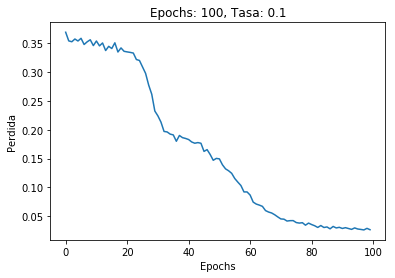

In [5]:
rn = RedNeuronal(NRO_ENTRADAS, K, "mse", [sigmoid, sigmoid_derivada], False)
rn.stochastic_gradient_descent(dataset, 100, 0.10, True)

Se puede apreciar que la curva sin momentum, tarda más que la curva con momentum en aprender, diferencia que se puede observar en los gráficos, donde los primeros 40 epochs, la implementación con momentum ya ronda entre los 0.00 y 0.05 de pérdida aproximadamente, mientras que nuestra última ejecución, sigue rondando entre los 0.20 y 0.15 de pérdida. Demostrando así, la razón del por qué el momentum es utilizado en la implementación de optimizadores, como lo es el de Keras. De acorde a: https://github.com/keras-team/keras/blob/master/keras/optimizers.py